In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Wine analysis

In [16]:
wine_train_df = pd.read_csv("datasets/benchmark/wine_train.csv")
wine_train_df["quality"] = wine_train_df["quality"].astype(int)
wine_train_df.to_csv("datasets/benchmark/wine_train.csv", index=False)

In [25]:
wine_train_df = pd.read_csv("datasets/benchmark/wine_train.csv")

X_wine_train = wine_train_df.loc[:, wine_train_df.columns != "quality"]
Y_wine_train = wine_train_df["quality"]

wine_test_df = pd.read_csv("datasets/benchmark/wine_test.csv")
X_wine_test = wine_test_df.loc[:, wine_test_df.columns != "quality"]
Y_wine_test = wine_test_df["quality"]

# Common Functions

In [47]:
def square_loss(y_true, y_pred):
    n = y_true.shape[0]
    return np.sum((y_pred - y_true) ** 2) / n

def rank_feature_importance(feature_name, feature_score):
    n = feature_name.shape[0]
    lst = [(feature_name[i], feature_score[i]) for i in range(n)]
    lst.sort(key=lambda x:x[1], reverse=True)
    # uncomment to see just the rank without the score
    # return [x[0] for x in lst]
    return lst

def select_features_filter(all_features, target_features):
    lst = []
    for i in range(len(all_features)):
        if all_features[i] in target_features:
            lst.append(True)
        else:
            lst.append(False)
    return lst

# Random Forest

In [7]:
from sklearn.ensemble import RandomForestClassifier

In [32]:
# Observation: when n_estimators=100 the ranked_importance changes!
n_estimators = 1000
for i in range(1):
    rf_clf = RandomForestClassifier(random_state=i, n_estimators=n_estimators)
    rf_clf.fit(X_wine_train, Y_wine_train)
    y_pred = rf_clf.predict(X_wine_test)
    loss = square_loss(Y_wine_test, y_pred)
    print(f"random state = {i}")
    print(f"loss = {loss}")
    ranked_importance = rank_feature_importance(X_wine_train.columns, rf_clf.feature_importances_)
    print(ranked_importance)

random state = 0
loss = 0.175
[('alcohol', 0.19079486402633025), ('sulphates', 0.12128757665374612), ('volatile acidity', 0.10749284388349215), ('total sulfur dioxide', 0.0970404136724533), ('density', 0.09207556091933009), ('chlorides', 0.07644063608148029), ('pH', 0.06680015955546138), ('fixed acidity', 0.06639475244123644), ('citric acid', 0.06512433343832831), ('free sulfur dioxide', 0.061920331944612245), ('residual sugar', 0.05462852738352938)]


In [33]:
all_features = list(X_wine_train.columns)
ranked_features = [ x[0] for x in ranked_importance]

random_states = [0, 1, 2, 3, 4]
num_estimators = 1000

square_loss_matrix = np.zeros((len(random_states), len(ranked_features)))
for i in range(len(random_states)):
    print(f"random state = {i}")
    rs = random_states[i]
    square_loss_lst = []
    for j in range(1, len(ranked_features) + 1):
        target_features = ranked_features[:j]
        features_filter = select_features_filter(all_features, target_features)
        X_wine_train_selected_features = X_wine_train.loc[:, features_filter]
        X_wine_test_selected_features = X_wine_test.loc[:, features_filter]
        rf_clf = RandomForestClassifier(random_state=rs, n_estimators=num_estimators)
        rf_clf.fit(X_wine_train_selected_features, Y_wine_train)
        square_loss_value = square_loss(Y_wine_test, rf_clf.predict(X_wine_test_selected_features))
        square_loss_lst.append(square_loss_value)
    square_loss_matrix[i,:] = np.array(square_loss_lst)

random state = 0
random state = 1
random state = 2
random state = 3
random state = 4


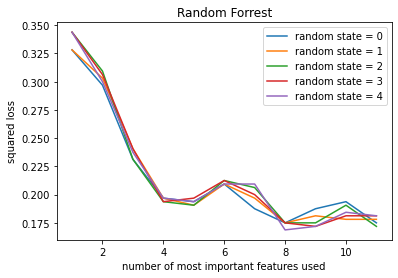

In [34]:
x_axis = np.arange(1, len(ranked_features) + 1)
for i in range(len(random_states)):
    plt.plot(x_axis,square_loss_matrix[i], label=f"random state = {i}")
plt.xlabel("number of most important features used")
plt.ylabel("squared loss")
plt.title("Random Forrest")
plt.legend()
plt.show()

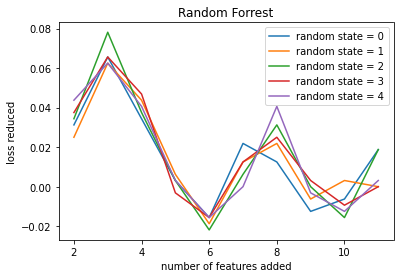

In [35]:
# squared loss difference
square_loss_matrix_0 = square_loss_matrix[:,:-1]
square_loss_matrix_1 = square_loss_matrix[:,1:]
square_loss_matrix_diff = square_loss_matrix_0 - square_loss_matrix_1

x_axis = np.arange(2, square_loss_matrix_diff.shape[1] + 2)
for i in range(len(random_states)):
    plt.plot(x_axis,square_loss_matrix_diff[i], label=f"random state = {i}")
plt.xlabel("number of features added")
plt.ylabel("loss reduced")
plt.title("Random Forrest")
plt.legend()
plt.show()


# Random forest selected features
Select top 8 performs almost as well as the complete set of features

In [71]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC


rf_selected_features = [x[0] for x in ranked_importance[:8]]
num_features = len(rf_selected_features)
X_wine_train_selected_features = X_wine_train.loc[:, rf_selected_features]
X_wine_test_selected_features = X_wine_test.loc[:, rf_selected_features]

print(f"{num_features} significant RF features with RF classifer ------")
num_estimators = 1000
rf_clf = RandomForestClassifier(random_state=rs, n_estimators=num_estimators)
rf_clf.fit(X_wine_train_selected_features, Y_wine_train)
y_pred = rf_clf.predict(X_wine_test_selected_features)

acc = accuracy_score(Y_wine_test, y_pred)
print(f"accuracy = {acc}")

f1 = f1_score(Y_wine_test, y_pred)
print(f"f1 score = {f1}")

con_matrix = confusion_matrix(Y_wine_test, y_pred)
print(f"confusion_matrix = {con_matrix}")

print(f"{num_features} significant RF features with Ridge classifer -----")
ridge_clf = RidgeClassifier()
ridge_clf.fit(X_wine_train_selected_features, Y_wine_train)
y_pred = ridge_clf.predict(X_wine_test_selected_features)

acc = accuracy_score(Y_wine_test, y_pred)
print(f"accuracy = {acc}")

f1 = f1_score(Y_wine_test, y_pred)
print(f"f1 score = {f1}")

con_matrix = confusion_matrix(Y_wine_test, y_pred)
print(f"confusion_matrix = {con_matrix}")

print(f"{num_features} significant RF features with SVC Classifer -----")
svc_clf = SVC()
svc_clf.fit(X_wine_train_selected_features, Y_wine_train)
y_pred = svc_clf.predict(X_wine_test_selected_features)

acc = accuracy_score(Y_wine_test, y_pred)
print(f"accuracy = {acc}")

f1 = f1_score(Y_wine_test, y_pred)
print(f"f1 score = {f1}")

con_matrix = confusion_matrix(Y_wine_test, y_pred)
print(f"confusion_matrix = {con_matrix}")


8 significant RF features with RF classifer ------
accuracy = 0.815625
f1 score = 0.8195718654434252
confusion_matrix = [[127  21]
 [ 38 134]]
8 significant RF features with Ridge classifer -----
accuracy = 0.74375
f1 score = 0.74375
confusion_matrix = [[119  29]
 [ 53 119]]
8 significant RF features with SVC Classifer -----
accuracy = 0.621875
f1 score = 0.7012345679012346
confusion_matrix = [[ 57  91]
 [ 30 142]]


# Lasso Feature Selection

In [36]:
from sklearn import linear_model
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import normalize

In [39]:
def select_feature(all_features, feature_filter):
    lst = []
    for i in range(len(feature_filter)):
        
        if feature_filter[i]:
            lst.append(all_features[i])
    return lst

n = 10
loss_lst = []
features_used = []
alphas = np.linspace(0.00001,0.008,30)
for a in alphas:
    # print(f"a = {a} =========")
    lasso_clf = linear_model.Lasso(alpha=a, normalize=True, random_state=1)
    lasso_clf.fit(X_wine_train, Y_wine_train)
    feature_filter = ~np.isclose(lasso_clf.coef_, 0)
    selected_features = select_feature(X_wine_train.columns, feature_filter)
    print(selected_features)
    y_pred = lasso_clf.predict(X_wine_test)
    loss = square_loss(Y_wine_test, y_pred)
    loss_lst.append(loss)
    features_used.append(np.sum(feature_filter))
    # print(f"loss = {loss}")

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
['volatile acidity', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'sulphates', 'alcohol']
['volatile acidity', 'chlorides', 'total sulfur dioxide', 'sulphates', 'alcohol']
['volatile acidity', 'chlorides', 'total sulfur dioxide', 'sulphates', 'alcohol']
['volatile acidity', 'total sulfur dioxide', 'sulphates', 'alcohol']
['volatile acidity', 'total sulfur dioxide', 'sulphates', 'alcohol']
['volatile acidity', 'total sulfur dioxide', 'sulphates', 'alcohol']
['volatile acidity', 'total sulfur dioxide', 'sulphates', 'alcohol']
['volatile acidity', 'total sulfur dioxide', 'sulphates', 'alcohol']
['volatile acidity', 'alcohol']
['volatile acidity', 'alcohol']
['volatile acidity', 'alcohol']
['volatile acidity', 'alcohol']
['volatile acidity', 'alcohol']
['volatile acidity', 'alcohol']
['alcohol']
['alcohol'

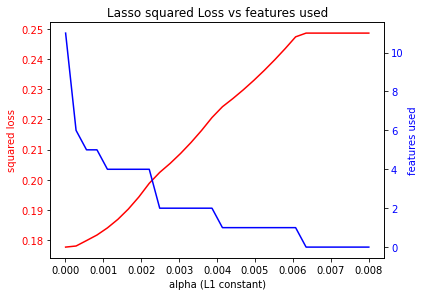

In [40]:
fig, ax1 = plt.subplots()

color = 'red'
ax1.set_xlabel('alpha (L1 constant)')
ax1.set_ylabel('squared loss', color=color)
ax1.plot(alphas, loss_lst, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'blue'
ax2.set_ylabel('features used', color=color)  # we already handled the x-label with ax1
ax2.plot(alphas, features_used, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Lasso squared Loss vs features used")

plt.show()

# LASSO selected features

['volatile acidity', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'sulphates', 'alcohol']
Random forest didn't use 'free sulfur dioxide'

In [72]:
lasso_selected_features = ['volatile acidity', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'sulphates', 'alcohol']
num_features = len(lasso_selected_features)
X_wine_train_selected_features = X_wine_train.loc[:, lasso_selected_features]
X_wine_test_selected_features = X_wine_test.loc[:, lasso_selected_features]

print(f"{num_features} significant LASSO features with RF classifer ------")
num_estimators = 1000
rf_clf = RandomForestClassifier(random_state=rs, n_estimators=num_estimators)
rf_clf.fit(X_wine_train_selected_features, Y_wine_train)
y_pred = rf_clf.predict(X_wine_test_selected_features)

acc = accuracy_score(Y_wine_test, y_pred)
print(f"accuracy = {acc}")

f1 = f1_score(Y_wine_test, y_pred)
print(f"f1 score = {f1}")

con_matrix = confusion_matrix(Y_wine_test, y_pred)
print(f"confusion_matrix = {con_matrix}")

print(f"{num_features} significant LASSO features with Ridge classifer -----")
ridge_clf = RidgeClassifier()
ridge_clf.fit(X_wine_train_selected_features, Y_wine_train)
y_pred = ridge_clf.predict(X_wine_test_selected_features)

acc = accuracy_score(Y_wine_test, y_pred)
print(f"accuracy = {acc}")

f1 = f1_score(Y_wine_test, y_pred)
print(f"f1 score = {f1}")

con_matrix = confusion_matrix(Y_wine_test, y_pred)
print(f"confusion_matrix = {con_matrix}")

print(f"{num_features} significant LASSO features with SVC Classifer -----")
svc_clf = SVC()
svc_clf.fit(X_wine_train_selected_features, Y_wine_train)
y_pred = svc_clf.predict(X_wine_test_selected_features)

acc = accuracy_score(Y_wine_test, y_pred)
print(f"accuracy = {acc}")

f1 = f1_score(Y_wine_test, y_pred)
print(f"f1 score = {f1}")

con_matrix = confusion_matrix(Y_wine_test, y_pred)
print(f"confusion_matrix = {con_matrix}")

6 significant LASSO features with RF classifer ------
accuracy = 0.7875
f1 score = 0.7926829268292682
confusion_matrix = [[122  26]
 [ 42 130]]
6 significant LASSO features with Ridge classifer -----
accuracy = 0.74375
f1 score = 0.7484662576687118
confusion_matrix = [[116  32]
 [ 50 122]]
6 significant LASSO features with SVC Classifer -----
accuracy = 0.63125
f1 score = 0.7035175879396984
confusion_matrix = [[ 62  86]
 [ 32 140]]
